In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 1. Importation des bibliothèques nécessaires et des datasets

In [53]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import BertTokenizer, BertModel, AdamW
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


In [54]:

sentences_dataset_url = "https://huggingface.co/datasets/imomayiz/darija-english/resolve/main/sentences.csv"

code_switching1_path  = "/kaggle/input/data-code-switching-1/data_code_switching1.xlsx"
code_switching2_path  = "/kaggle/input/data-code-switching-1/data_code_switching2.xlsx"

sentences_df = pd.read_csv(sentences_dataset_url)  # CSV

code_switching1_df = pd.read_excel(code_switching1_path, engine="openpyxl")
code_switching2_df = pd.read_excel(code_switching2_path, engine="openpyxl")


print("sentences_df.shape :", sentences_df.shape)

print("code_switching1_df.shape:", code_switching1_df.shape)
print("code_switching2_df.shape:", code_switching2_df.shape)

sentences_df.shape : (87785, 3)
code_switching1_df.shape: (999, 1)
code_switching2_df.shape: (869, 1)


# Preparation des données

In [55]:
code_switching1_df = code_switching1_df.rename(columns={code_switching1_df.columns[0]: "text"})
code_switching2_df = code_switching2_df.rename(columns={code_switching2_df.columns[0]: "text"})

combined1_df = pd.concat([ code_switching1_df,code_switching2_df], ignore_index=True)
combined1_df = combined1_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(combined1_df.shape)
print(combined1_df.head())


def clean_text(text):
    if not isinstance(text, str):
        text = str(text) 
    text = re.sub(r'[^\w\s]', '', text)
    text = text.replace('"', '')
    text = re.sub(r'^\d+\s*', '', text)
    text = re.sub(r'(?<!\w)[^\w\s\']+|[^\w\s\']+(?!\w)', '', text)
    return text

combined1_df["text"] = combined1_df["text"].fillna("").apply(clean_text)
print("Aperçu des données nettoyées :")
print(combined1_df.head())

(1868, 1)
                                                text
0        “The file rah missing mn the shared drive.”
1  “Khasni analyze kifash kan the performance res...
2  923. “Enta let’s consider using an in-memory c...
3  277. “Rah the cron job might be failing due to...
4  418. “Rah let’s do some load testing using a t...
Aperçu des données nettoyées :
                                                text
0           The file rah missing mn the shared drive
1  Khasni analyze kifash kan the performance results
2  Enta lets consider using an inmemory cache for...
3  Rah the cron job might be failing due to a con...
4  Rah lets do some load testing using a tool lik...


In [56]:
def clean_text1(text):
    if isinstance(text, str):  
        return re.sub(r'[^\w\s]', '', text)  
    return text 

df_darija = sentences_df[['darija']].copy()

print("Tableau Darija :")
print(df_darija.head())
print(df_darija.shape)

sampled_df_darija = df_darija.sample(n=2644, random_state=42).reset_index(drop=True)

print(sampled_df_darija.head())
sampled_df_darija["darija"] = sampled_df_darija["darija"].fillna("").apply(clean_text).apply(clean_text1)
print(sampled_df_darija.shape) 

Tableau Darija :
                                   darija
0    homa mkhbbyin chi haja, ana mti99en!
1      bayna homa tay7awlo ib9aw mbrrdin.
2  loTilat mabaynach fihom mori7in bzzaf.
3      ghaliban ghayjrriw 3lih mn lkhdma!
4                     Tab3an rah mkta2eb!
(87785, 1)
                                  darija
0  chnou hia a7ssn blassa saferti liha ?
1            sir bniya ou rged m3a l7eya
2      jarabt dart chbkat dlbasla obtata
3                          rah ba9i l7al
4          raki sme3ti tbib achnou galik
(2644, 1)


In [57]:
df_english = sentences_df[['eng']].copy()
df_english ["eng"] = df_english ["eng"].fillna("").apply(clean_text)

def extract_clean_non_empty(dataframe, column_name):
    # Vérifiez si la colonne existe
    if column_name not in dataframe.columns:
        raise ValueError(f"La colonne '{column_name}' n'existe pas dans la DataFrame.")

    non_empty = dataframe[column_name].dropna()
    non_empty = non_empty[non_empty.str.strip() != '']  

    return non_empty.drop_duplicates()

cleaned_eng = extract_clean_non_empty(df_english, 'eng')

cleaned_df = pd.DataFrame(cleaned_eng, columns=['eng'])

print(f"Nombre de valeurs non vides nettoyées : {len(cleaned_df)}")
print(cleaned_df.head())

print(f"Colonnes du DataFrame nettoyé : {cleaned_df.columns.tolist()}")

sampled_df_english = cleaned_df.sample(n=2645, random_state=42).reset_index(drop=True)
sampled_df_english["eng"] =sampled_df_english["eng"].fillna("").apply(clean_text)
print(sampled_df_english.head())
print(sampled_df_english.shape)

Nombre de valeurs non vides nettoyées : 11403
                                                 eng
0                    Theyre hiding something Im sure
1       Its obvious theyre trying to keep their cool
2              the hotels dont seem very comfortable
3  he is probably about to be laid off by head of...
4                           of course hes depressive
Colonnes du DataFrame nettoyé : ['eng']
                                         eng
0  Have you been in a moroccan 7ammam before
1                       I cant see the light
2                          A detective novel
3         i believe it should be on discount
4             He is on his last legs you see
(2645, 1)


In [58]:
print(f"Taille du dataset Darija: {sampled_df_darija.shape[0]} phrases")
print(f"Taille du dataset Anglais: {sampled_df_english.shape[0]} phrases")
print(f"Taille du dataset Code-Switching: {combined1_df.shape[0]} phrases")

Taille du dataset Darija: 2644 phrases
Taille du dataset Anglais: 2645 phrases
Taille du dataset Code-Switching: 1868 phrases


In [59]:

sampled_df_darija.rename(columns={"darija": "text"}, inplace=True)
sampled_df_english.rename(columns={"eng": "text"}, inplace=True)
combined1_df.rename(columns={"code_switching": "text"}, inplace=True)

sampled_df_darija["label"] = 0  # Label 0 pour Darija
sampled_df_english["label"] = 1  # Label 1 pour Anglais
combined1_df["label"] = 2  # Label 2 pour Code-switching

print("Colonnes dans sampled_df_darija :", sampled_df_darija.columns)
print("Colonnes dans sampled_df_english :", sampled_df_english.columns)
print("Colonnes dans combined1_df :", combined1_df.columns)
print(sampled_df_darija.head())
print(sampled_df_english.head())
print(combined1_df.head())
print(combined1_df.shape)

Colonnes dans sampled_df_darija : Index(['text', 'label'], dtype='object')
Colonnes dans sampled_df_english : Index(['text', 'label'], dtype='object')
Colonnes dans combined1_df : Index(['text', 'label'], dtype='object')
                                   text  label
0  chnou hia a7ssn blassa saferti liha       0
1           sir bniya ou rged m3a l7eya      0
2     jarabt dart chbkat dlbasla obtata      0
3                         rah ba9i l7al      0
4         raki sme3ti tbib achnou galik      0
                                        text  label
0  Have you been in a moroccan 7ammam before      1
1                       I cant see the light      1
2                          A detective novel      1
3         i believe it should be on discount      1
4             He is on his last legs you see      1
                                                text  label
0           The file rah missing mn the shared drive      2
1  Khasni analyze kifash kan the performance results      2
2  En

# Concaténer les datasets et tokenisation

In [60]:

combined_df = pd.concat([sampled_df_darija, sampled_df_english, combined1_df], ignore_index=True)
print(combined_df.head(10))

                                   text  label
0  chnou hia a7ssn blassa saferti liha       0
1           sir bniya ou rged m3a l7eya      0
2     jarabt dart chbkat dlbasla obtata      0
3                         rah ba9i l7al      0
4         raki sme3ti tbib achnou galik      0
5                daba achnou ghadi diri      0
6                    lmohim thlay frask      0
7           ghit ykon transport rah mzn      0
8              mli tkhrej sed m3ak lbab      0
9     ochki bih o ila madaro m3ak walou      0


In [62]:
print("Tokenisation...")
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

def tokenize_data(texts, tokenizer, max_len=100):
    return tokenizer(
        texts,
        padding='max_length',
        truncation=True,
        max_length=max_len,
        return_tensors="pt"
    )

X = combined_df['text']
y = combined_df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

train_encodings = tokenize_data(X_train.tolist(), tokenizer)
test_encodings = tokenize_data(X_test.tolist(), tokenizer)
print("tokenisation terminer")

Tokenisation...
tokenisation terminer


# Préparation des données pour PyTorch

In [63]:

print("Préparation des données pour PyTorch...")
class CodeSwitchingDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': torch.tensor(self.labels.iloc[idx], dtype=torch.long)
        }

train_dataset = CodeSwitchingDataset(train_encodings, y_train.reset_index(drop=True))
test_dataset = CodeSwitchingDataset(test_encodings, y_test.reset_index(drop=True))

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

print("Construction du modèle...")
class CodeSwitchingClassifier(nn.Module):
    def __init__(self):
        super(CodeSwitchingClassifier, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, 3)  # 3 classes

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        dropout_output = self.dropout(pooled_output)
        logits = self.classifier(dropout_output)
        return logits

model = CodeSwitchingClassifier()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


Préparation des données pour PyTorch...
Construction du modèle...


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

CodeSwitchingClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, 

# Entraînement du modèle mBERT

In [15]:

print("Initialisation de l'entraînement...")
optimizer = AdamW(model.parameters(), lr=5e-5)
criterion = nn.CrossEntropyLoss()

print("Entraînement...")
from tqdm import tqdm

num_epochs = 3
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f"Loss: {epoch_loss / len(train_loader):.4f}")

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Initialisation de l'entraînement...
Entraînement...

Epoch 1/3


Training Epoch 1: 100%|██████████| 358/358 [01:01<00:00,  5.81it/s]


Loss: 0.0937

Epoch 2/3


Training Epoch 2: 100%|██████████| 358/358 [01:00<00:00,  5.88it/s]


Loss: 0.0321

Epoch 3/3


Training Epoch 3: 100%|██████████| 358/358 [01:00<00:00,  5.88it/s]

Loss: 0.0221


Evaluation du model (classification repport et matrice de confusion )

Évaluation du modèle...
Classification Report:
                precision    recall  f1-score   support

        Darija       0.99      1.00      1.00       538
       English       0.99      0.99      0.99       525
Code-Switching       1.00      0.99      0.99       369

      accuracy                           0.99      1432
     macro avg       0.99      0.99      0.99      1432
  weighted avg       0.99      0.99      0.99      1432

Confusion Matrix:
[[536   2   0]
 [  3 521   1]
 [  0   4 365]]


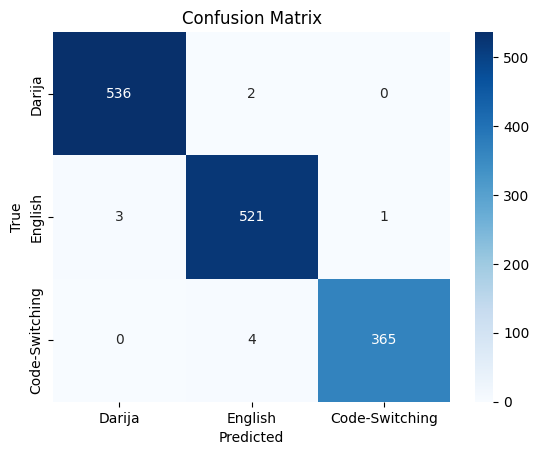

In [16]:
print("Évaluation du modèle...")
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        predictions = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().tolist())
        y_pred.extend(predictions.cpu().tolist())

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Darija', 'English', 'Code-Switching']))

print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Darija', 'English', 'Code-Switching'], yticklabels=['Darija', 'English', 'Code-Switching'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# fine_tuning du model BERT (

In [17]:
print("Initialisation de l'entraînement avec Fine-Tuning...")

for param in model.bert.parameters():
    param.requires_grad = False  # Geler les poids de BERT


for param in model.bert.encoder.layer[-2:].parameters():
    param.requires_grad = True  # Fine-tuning sur les 2 dernières couches

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Nombre de paramètres entraînables : {trainable_params}")

optimizer = AdamW([
    {'params': model.bert.encoder.layer[-2:].parameters(), 'lr': 1e-5},  # Fine-tuning sur les couches de BERT
    {'params': model.classifier.parameters(), 'lr': 5e-5}  # Taux plus élevé pour le classifieur
])

criterion = nn.CrossEntropyLoss()

print("Entraînement avec Fine-Tuning...")
from tqdm import tqdm

num_epochs = 5 
model.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    print(f"\nEpoch {epoch + 1}/{num_epochs}")
    for batch in tqdm(train_loader, desc=f"Fine-Tuning Epoch {epoch + 1}"):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f"Loss: {epoch_loss / len(train_loader):.4f}")

for param in model.bert.parameters():
    param.requires_grad = True


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Initialisation de l'entraînement avec Fine-Tuning...
Nombre de paramètres entraînables : 14178051
Entraînement avec Fine-Tuning...

Epoch 1/5


Fine-Tuning Epoch 1: 100%|██████████| 358/358 [00:23<00:00, 15.29it/s]


Loss: 0.0125

Epoch 2/5


Fine-Tuning Epoch 2: 100%|██████████| 358/358 [00:23<00:00, 15.39it/s]


Loss: 0.0103

Epoch 3/5


Fine-Tuning Epoch 3: 100%|██████████| 358/358 [00:23<00:00, 15.37it/s]


Loss: 0.0074

Epoch 4/5


Fine-Tuning Epoch 4: 100%|██████████| 358/358 [00:23<00:00, 15.36it/s]


Loss: 0.0071

Epoch 5/5


Fine-Tuning Epoch 5: 100%|██████████| 358/358 [00:23<00:00, 15.36it/s]

Loss: 0.0068


evaluation du model

Évaluation du modèle...
Classification Report:
                precision    recall  f1-score   support

        Darija       0.99      1.00      1.00       538
       English       0.99      0.99      0.99       525
Code-Switching       0.99      0.99      0.99       369

      accuracy                           0.99      1432
     macro avg       0.99      0.99      0.99      1432
  weighted avg       0.99      0.99      0.99      1432

Confusion Matrix:
[[537   0   1]
 [  3 520   2]
 [  0   4 365]]


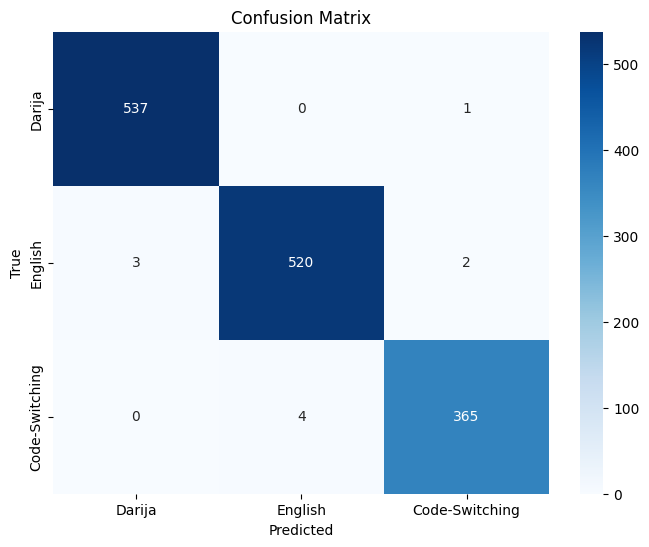

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

print("Évaluation du modèle...")
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        predictions = torch.argmax(outputs, dim=1)
        y_true.extend(labels.cpu().tolist())
        y_pred.extend(predictions.cpu().tolist())


print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Darija', 'English', 'Code-Switching']))



print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Darija', 'English', 'Code-Switching'], yticklabels=['Darija', 'English', 'Code-Switching'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Prediction

In [34]:

print("Initialisation des prédictions...")

def predict_text(text, model, tokenizer, device):
    model.eval()
    classes = ['Darija', 'English', 'Code-Switching']

    inputs = tokenizer(
        text,
        padding='max_length',
        truncation=True,
        max_length=100,
        return_tensors="pt"
    )

    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

   
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        prediction = torch.argmax(outputs, dim=1).item()

    return classes[prediction]


print("Exemple de prédiction...")
example_texts = [
    "chnou hia a7ssn blassa saferti liha",
    "I need to go home",
    "It's been 15 minutes since I've seen her!",
    "raki sme3ti tbib achnou galik",
    "kifach kan your day",
    "can i have zit m3ak", 
    "can you give me the phone",
    "wach nta cv pas",
    "forgive me ana m3ak ",
    "Please 3tini l password dyal Wi-Fi rah service kherj",
]

for text in example_texts:
    predicted_class = predict_text(text, model, tokenizer, device)
    print(f"Texte : {text}\nClasse prédite : {predicted_class}\n")


Initialisation des prédictions...
Exemple de prédiction...
Texte : chnou hia a7ssn blassa saferti liha
Classe prédite : Darija

Texte : I need to go home
Classe prédite : English

Texte : It's been 15 minutes since I've seen her!
Classe prédite : English

Texte : raki sme3ti tbib achnou galik
Classe prédite : Darija

Texte : kifach kan your day
Classe prédite : Code-Switching

Texte : can i have zit m3ak
Classe prédite : Code-Switching

Texte : can you give me the phone
Classe prédite : English

Texte : wach nta cv pas
Classe prédite : Darija

Texte : forgive me ana m3ak 
Classe prédite : Code-Switching

Texte : Please 3tini l password dyal Wi-Fi rah service kherj
Classe prédite : Code-Switching



 # Modèle BiLSTM avec intégration des embeddings GloVe

In [36]:
# 1. Importation des bibliothèques nécessaires
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Préparation des données

In [37]:
print("Préparation des données...")
max_vocab_size = 10000  
max_sequence_length = 100 
embedding_dim = 100  

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(combined_df['text'])
sequences = tokenizer.texts_to_sequences(combined_df['text'])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')
labels = combined_df['label'].values

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=3)
y_test = to_categorical(y_test, num_classes=3)

print(f"Forme de X_train : {X_train.shape}, y_train : {y_train.shape}")

Préparation des données...
Forme de X_train : (5725, 100), y_train : (5725, 3)


# Chargement des embeddings GloVe

In [38]:
print("Chargement des embeddings GloVe...")
embeddings_index = {}
with open("/kaggle/input/glove-dataset/glove.6B.100d.txt", encoding="utf-8") as f:  # Remplacez par le chemin du fichier GloVe
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print(f"Nombre de mots dans GloVe : {len(embeddings_index)}")

# Création de la matrice d'embeddings
embedding_matrix = np.zeros((max_vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_vocab_size:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Chargement des embeddings GloVe...
Nombre de mots dans GloVe : 400000


# construction ET entrainement du model bilSTM

In [39]:

print("Construction du modèle BiLSTM...")
model = Sequential([
    Embedding(input_dim=max_vocab_size, 
              output_dim=embedding_dim, 
              weights=[embedding_matrix], 
              input_length=max_sequence_length, 
              trainable=False),  # Embeddings non entraînables
    Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)),
    Bidirectional(LSTM(units=64, dropout=0.3, recurrent_dropout=0.3)),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')  # 3 classes : Darija, English, Code-Switching
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# 5. Entraînement du modèle
print("Entraînement du modèle BiLSTM avec GloVe...")
history = model.fit(
    X_train, y_train,
    epochs=10,  # Ajustez selon vos besoins
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)


Construction du modèle BiLSTM...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

Entraînement du modèle BiLSTM avec GloVe...
Epoch 1/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 86s 429ms/step - accuracy: 0.8450 - loss: 0.4120 - val_accuracy: 0.9825 - val_loss: 0.0595
Epoch 2/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 421ms/step - accuracy: 0.9754 - loss: 0.0853 - val_accuracy: 0.9853 - val_loss: 0.0453
Epoch 3/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 421ms/step - accuracy: 0.9835 - loss: 0.0636 - val_accuracy: 0.9860 - val_loss: 0.0489
Epoch 4/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 420ms/step - accuracy: 0.9837 - loss: 0.0619 - val_accuracy: 0.9874 - val_loss: 0.0332
Epoch 5/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 419ms/step - accuracy: 0.9838 - loss: 0.0517 - val_accuracy: 0.9874 - val_loss: 0.0456
Epoch 6/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 418ms/step - accuracy: 0.9891 - loss: 0.0406 - val_accuracy: 0.9881 - val_loss: 0.0344
Epoch 7/10
179/179 ━━━━━━━━━━━━━━━━━━━━ 75s 418ms/step - accuracy: 0.9906 - loss: 0.0465 - val_accuracy: 0.9874 - val_loss: 0.0431
Epoch 8/10
179/179 ━━━━━━━━━━━━━━━━━━━━

# evaluation du model BiLSTM

Évaluation du modèle BiLSTM...
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.9955 - loss: 0.0217
Perte : 0.0285, Précision : 0.9930
Analyse des performances...
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 100ms/step
Classification Report:
                precision    recall  f1-score   support

        Darija       1.00      1.00      1.00       538
       English       0.99      0.99      0.99       525
Code-Switching       1.00      0.98      0.99       369

      accuracy                           0.99      1432
     macro avg       0.99      0.99      0.99      1432
  weighted avg       0.99      0.99      0.99      1432

Confusion Matrix:
[[538   0   0]
 [  2 522   1]
 [  0   7 362]]


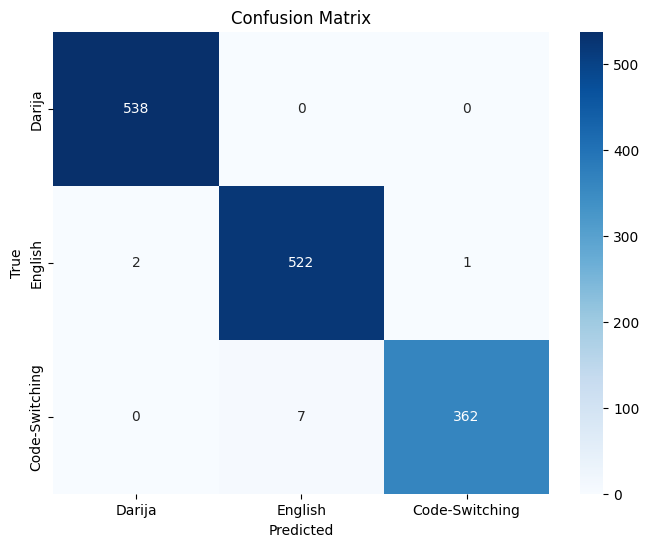

In [40]:

print("Évaluation du modèle BiLSTM...")
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Perte : {loss:.4f}, Précision : {accuracy:.4f}")


print("Analyse des performances...")


y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=['Darija', 'English', 'Code-Switching']))


print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred_classes)
print(cm)

# Visualisation de la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Darija', 'English', 'Code-Switching'], yticklabels=['Darija', 'English', 'Code-Switching'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



# prediction

In [50]:

print("Prédictions sur de nouvelles phrases...")
def predict_text(text, model, tokenizer, max_sequence_length):
    """Prédire la classe d'une phrase donnée."""
    classes = ['Darija', 'English', 'Code-Switching']
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length, padding='post')
    prediction = model.predict(padded_sequence)
    predicted_class = np.argmax(prediction, axis=1)[0]
    return classes[predicted_class]

example_texts = [
    "kifach kan your day?",
    "I need to go home now.",
    "chnou hia a7ssn blassa saferti liha",
    "Let's go whit the friends!",
    "give me lwe9t",
    "how was nhar dialek",
    " give me the makla"
]

for text in example_texts:
    predicted_class = predict_text(text, model, tokenizer, max_sequence_length)
    print(f"Texte : {text}\nClasse prédite : {predicted_class}\n")


Prédictions sur de nouvelles phrases...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
Texte : kifach kan your day?
Classe prédite : Code-Switching

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Texte : I need to go home now.
Classe prédite : English

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
Texte : chnou hia a7ssn blassa saferti liha
Classe prédite : Darija

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Texte : Let's go whit the friends!
Classe prédite : Code-Switching

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
Texte : give me lwe9t
Classe prédite : English

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
Texte : how was nhar dialek
Classe prédite : English

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Texte :  give me the makla
Classe prédite : English

